# Tests for Symbolic Regression with autonames

In [1]:
pip install git+https://github.com/Program-Trace-Optimisation/PTO.git

  Cloning https://github.com/Program-Trace-Optimisation/PTO.git to /tmp/pip-req-build-6a8sz88r
  Running command git clone --filter=blob:none --quiet https://github.com/Program-Trace-Optimisation/PTO.git /tmp/pip-req-build-6a8sz88r
  Resolved https://github.com/Program-Trace-Optimisation/PTO.git to commit 7e9a3e542a9a8834cfb82a133d7c7d5b9d2586c9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PTO: filename=pto-0.2-py3-none-any.whl size=69595 sha256=d03907d78586bf4202b22dd2414d1121bd8f81a9905371804b42adce94a9a018
  Stored in directory: /tmp/pip-ephem-wheel-cache-ox0xp1u6/wheels/ab/58/d8/e6f2844ecd6a37a8ee18855d216dd6155fdecfea3063e33115
Successfully built PTO


In [14]:
# SYMBOLIC REGRESSION

from pto import run, rnd

import random  # for generating problem data
import math


#################
# INSTANCE DATA #
#################


def make_training_data(n_samples, n_vars, func_set, term_set):
    target_str = cnf_generator(n_vars)
    #target_str = generator(func_set, term_set)
    print(target_str)
    target = eval("lambda x: " + target_str)
    X = [
        [random.choice([False, True]) for _ in range(n_vars)] for _ in range(n_samples)
    ]  # training inputs
    y = [target(xi) for xi in X]  # training outputs
    return X, y


better = min


def full(func_set, term_set):  # unused
    max_depth = math.log2(
        len(term_set)
    )  # estimate required depth. imperfect because we have 'not'

    def _full(depth):
        if depth >= max_depth:
            expr = random.choice(
                term_set
            )  # use random, not rnd, as this is for creation of problem instance
        else:
            func, arity = random.choice(func_set)
            if arity == 1:
                expr = "(%s %s)" % (func, _full(depth + 1))
            else:  # arity = 2
                expr = "(%s %s %s)" % (_full(depth + 1), func, _full(depth + 1))
        return expr

    return _full(0)


def cnf_generator(s):
    # an alternative target generator
    # we have s variables, and we combine them in cnf
    assert s % 3 == 0
    conjs = (f"(x[{i}] and x[{i+1}] and not x[{i+2}])" for i in range(0, s, 3))
    expr = " or ".join(conjs)
    # print(expr)
    return expr


######################
# SOLUTION GENERATOR #
######################


# generate random expression
def generator(func_set, term_set):

    def rnd_expr(depth):  # Growth Initialisation
        if depth <= 0 or rnd.random() < 1/depth: #len(term_set) / (len(term_set) + len(func_set)):
            expr = rnd.choice(term_set)
        else:
            func, arity = rnd.choice(func_set)
            if arity == 1:
                expr = "(%s %s)" % (func, rnd_expr(depth - 1))
            else:  # arity = 2
                expr = "(%s %s %s)" % (rnd_expr(depth - 1), func, rnd_expr(depth - 1))
        return expr

    max_depth = 6
    return rnd_expr(max_depth)


####################
# FITNESS FUNCTION #
####################


# fitness
def fitness(expr, X, y):

    # string to function
    f = eval("lambda x: " + expr)

    # predictions on traning set
    yhat = [f(xi) for xi in X]

    # error on traing set
    err = sum(abs(yhati - yi) for (yhati, yi) in zip(yhat, y))

    return err


if __name__ == "__main__":

    n_vars = 9  # problem size (number of input variables)
    func_set = [("and", 2), ("or", 2), ("not", 1)]  # functions set
    term_set = [f"x[{i}]" for i in range(n_vars)]  # terminals set

    # create training set
    n_samples = n_vars * 10  # training set size
    X_train, y_train = make_training_data(n_samples, n_vars, func_set, term_set)

    sol, _, _ = run(
        generator,
        fitness,
        gen_args=(func_set, term_set),
        fit_args=(X_train, y_train),
        better=better,
        Solver="particle_swarm_optimisation",
        solver_args={"n_iteration": 100},
    )
    print(f"Solution {sol}")
    print(f"Fitness {fitness(sol.pheno, X_train, y_train)}")

(x[0] and x[1] and not x[2]) or (x[3] and x[4] and not x[5]) or (x[6] and x[7] and not x[8])
Solution Sol(pheno='((not x[8]) and (x[6] and (not (not (x[7] or x[4])))))', geno={'root/rnd_expr(6,)@(15,70)/random@(4,62)': Random_real(random, (), {}, val=0.563505728981572), 'root/rnd_expr(6,)@(15,70)/choice@(7,182)': Random_cat(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('and', 2)), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/random@(4,62)': Random_real(random, (), {}, val=0.8846229379482565), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/choice@(7,182)': Random_cat(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('not', 1)), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/rnd_expr(4,)@(9,236)/random@(4,62)': Random_real(random, (), {}, val=0.19264891610057455), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/rnd_expr(4,)@(9,236)/choice@(5,128)': Random_cat(choice, (['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]'],), {}, val=x[8]), 'ro

In [2]:
"search_operators"

op = run(
        generator,
        fitness,
        gen_args=(func_set, term_set),
        fit_args=(X_train, y_train),
        better=better,
        Solver="search_operators"
    )




In [3]:
from pprint import pprint

In [4]:
rnd.CONFIG(name_type='str', dist_type='coarse')
par_sol = op.create_ind()
par_fit = op.evaluate_ind(sol)
print(par_sol.pheno, par_fit)
pprint(par_sol.geno)

(x[3] or (((x[3] and (x[7] and x[4])) and (x[3] or (x[5] and x[6]))) or (x[7] and (not (x[2] and x[6]))))) 9
{'root/rnd_expr(6,)@(15,70)/choice@(7,182)': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('or', 2)),
 'root/rnd_expr(6,)@(15,70)/random@(4,62)': Dist(random, (), {}, val=0.7187799129726359),
 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/choice@(5,128)': Dist(choice, (['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]'],), {}, val=x[3]),
 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/random@(4,62)': Dist(random, (), {}, val=0.06787249180264254),
 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,310)/choice@(7,182)': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('or', 2)),
 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,310)/random@(4,62)': Dist(random, (), {}, val=0.9602474407875925),
 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,310)/rnd_expr(4,)@(11,274)/choice@(7,182)': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, 

In [5]:
off_sol = op.mutate_ind(sol)
# Resample offspring until its genotype length is different from parent's
while len(off_sol.geno) == len(par_sol.geno):
  off_sol = op.mutate_ind(par_sol)
off_fit = op.evaluate_ind(off_sol)
off_sol.pheno, off_fit

('(not (((not (x[6] and x[7])) or (((x[3] or x[2]) and x[0]) and x[8])) or ((x[8] or (x[7] and x[5])) and (x[2] and (not x[4])))))',
 9)

In [6]:
import numpy as np

def analyze_mutation_operator(op_object, num_iterations=100, min_len=0):
    parent_fitnesses = []
    offspring_fitnesses = []
    parent_geno_lengths = []

    for _ in range(num_iterations):
        parent_sol = None
        # Retry generating parent solution until its genotype length is at least min_len
        while parent_sol is None or len(parent_sol.geno) < min_len:
            parent_sol = op_object.create_ind()

        # 2. Mutate the parent solution to create an offspring
        offspring_sol = op_object.mutate_ind(parent_sol)
        # Resample offspring until its genotype length is different from parent's
        while len(offspring_sol.geno) == len(parent_sol.geno):
            offspring_sol = op_object.mutate_ind(parent_sol)

        # 3. Compute the fitness for both parent and offspring
        parent_fit = op_object.evaluate_ind(parent_sol)
        offspring_fit = op_object.evaluate_ind(offspring_sol)

        parent_fitnesses.append(parent_fit)
        offspring_fitnesses.append(offspring_fit)

        # Get length of parent genotype (trace)
        parent_geno_lengths.append(len(parent_sol.geno))

    # 5. Compute the correlation between parent and offspring fitness
    correlation = np.corrcoef(parent_fitnesses, offspring_fitnesses)[0, 1]

    # 6. Return the average length of parent trace
    average_parent_length = np.mean(parent_geno_lengths)

    return correlation, average_parent_length

In [7]:
# Run the analysis with 100 iterations
rnd.CONFIG(name_type='str', dist_type='coarse')
correlation, avg_length = analyze_mutation_operator(op, num_iterations=1000, min_len=15)

print(f"Correlation between parent and offspring fitness: {correlation:.4f}")
print(f"Average length of parent phenotype: {avg_length:.2f}")

Correlation between parent and offspring fitness: 0.8242
Average length of parent phenotype: 31.66


In [10]:
# Run the analysis with 100 iterations
rnd.CONFIG(name_type='lin', dist_type='coarse')
correlation, avg_length = analyze_mutation_operator(op, num_iterations=1000, min_len=15)

print(f"Correlation between parent and offspring fitness: {correlation:.4f}")
print(f"Average length of parent phenotype: {avg_length:.2f}")

Correlation between parent and offspring fitness: 0.5982
Average length of parent phenotype: 33.51


In [11]:
sol, fx, _ = run(
        generator,
        fitness,
        name_type="str", dist_type="coarse",
        gen_args=(func_set, term_set),
        fit_args=(X_train, y_train),
        better=min,
        Solver="hill_climber",
        solver_args={"n_generation":1000},
    )
print(f"Solution {sol}")
print(f"Fitness {fx}")

Solution Sol(pheno='((not (((not x[7]) or (not x[6])) or (x[1] and x[2]))) and ((not ((not x[7]) and x[6])) and ((not x[5]) or (not (x[2] or x[3])))))', geno={'root/rnd_expr(6,)@(15,70)/random@(4,62)': Dist(random, (), {}, val=0.5144496404094475), 'root/rnd_expr(6,)@(15,70)/choice@(7,182)': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('and', 2)), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/random@(4,62)': Dist(random, (), {}, val=0.35647846442244846), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/choice@(7,182)': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('not', 1)), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/rnd_expr(4,)@(9,236)/random@(4,62)': Dist(random, (), {}, val=0.3020150050080046), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/rnd_expr(4,)@(9,236)/choice@(7,182)': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('or', 2)), 'root/rnd_expr(6,)@(15,70)/rnd_expr(5,)@(11,274)/rnd_expr(4,)@(9,236)/rnd_expr(3,)@(11,274

In [12]:
sol, fx, _ = run(
        generator,
        fitness,
        name_type="lin", dist_type="coarse",
        gen_args=(func_set, term_set),
        fit_args=(X_train, y_train),
        better=min,
        Solver="hill_climber",
        solver_args={"n_generation": 1000},
    )
print(f"Solution {sol}")
print(f"Fitness {fx}")

Solution Sol(pheno='((not ((not x[4]) or (x[5] or (not x[7])))) and ((((x[5] or x[5]) or x[3]) or ((not x[0]) and x[5])) or (x[4] and (not x[2]))))', geno={'0': Dist(random, (), {}, val=0.7641879544569677), '1': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('and', 2)), '2': Dist(random, (), {}, val=0.9026575894302681), '3': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('not', 1)), '4': Dist(random, (), {}, val=0.37380634858614636), '5': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('or', 2)), '6': Dist(random, (), {}, val=0.9709226208193743), '7': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('not', 1)), '8': Dist(random, (), {}, val=0.32513016771472725), '9': Dist(choice, (['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]'],), {}, val=x[4]), '10': Dist(random, (), {}, val=0.9377220876804448), '11': Dist(choice, ([('and', 2), ('or', 2), ('not', 1)],), {}, val=('or', 2)), '12': Dist(random, (), {}, val=

Correlogram Analysis for ONEMAX (Colab-Compatible)

Configuration:
  Problem size: 50
  Random walks: 40
  Walk length: 15
  Distance bins: 20

Creating Op instance...

Building correlogram...
Building correlogram with 40 walks of length 15...
Step 1: Generating random walks...
  Completed 10/40 walks...
  Completed 20/40 walks...
  Completed 30/40 walks...
  Completed 40/40 walks...
  Total solutions generated: 640
Step 2: Computing fitness statistics...
  Mean fitness: 24.9219
  Fitness variance: 10.6439
Step 3: Computing pairwise distances...
  Computing 204480 pairwise distances...
  Processed 100/640 solutions...
  Processed 200/640 solutions...
  Processed 300/640 solutions...
  Processed 400/640 solutions...
  Processed 500/640 solutions...
  Processed 600/640 solutions...
Step 4: Distance statistics:
  Average distance: 24.6516
  Max distance: 41.0000
  Min distance: 0.0000
Step 5: Binning distances into 20 bins...
  Non-empty bins: 20/20

Correlogram completed!
Correlation at 

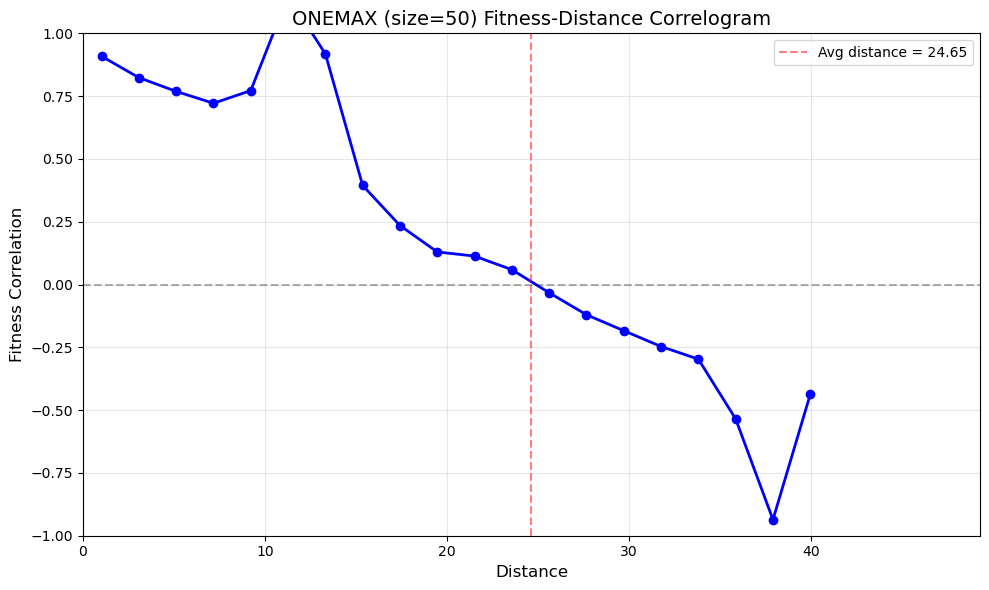


Complete!


In [ ]:
"""
Colab-ready example for correlogram analysis.

Instructions for Google Colab:
1. Upload this file to your Colab session or clone the PTO repository
2. Run this script
3. The correlogram will be generated and plotted

This works correctly in Colab because the generator function is defined
in a .py file (stable source location), not in a Colab cell.
"""

from pto import run, rnd
from pto.solvers.correlogram_walks import correlogram_walks

# Define problem in this file (not in Colab cell!)
def generatorOM(size):
    """Generate random binary string"""
    return [rnd.choice([0, 1]) for i in range(size)]

def fitnessOM(solution):
    """Count number of ones (ONEMAX)"""
    return sum(solution)

# Main execution
if __name__ == "__main__":
    print("="*60)
    print("Correlogram Analysis for ONEMAX (Colab-Compatible)")
    print("="*60)

    # Configuration
    PROBLEM_SIZE = 50
    N_WALKS = 40
    WALK_LENGTH = 15
    N_BINS = 20

    print(f"\nConfiguration:")
    print(f"  Problem size: {PROBLEM_SIZE}")
    print(f"  Random walks: {N_WALKS}")
    print(f"  Walk length: {WALK_LENGTH}")
    print(f"  Distance bins: {N_BINS}")

    # Create Op instance
    print("\nCreating Op instance...")
    op = run(
        generatorOM,
        fitnessOM,
        gen_args=(PROBLEM_SIZE,),
        better=max,
        Solver="search_operators"
    )

    # Build correlogram
    print("\nBuilding correlogram...")
    analyzer = correlogram_walks(
        op,
        n_walks=N_WALKS,
        walk_length=WALK_LENGTH,
        n_bins=N_BINS,
        verbose=True
    )

    x_axis, y_axis = analyzer()

    # Display results
    results = analyzer.get_results()

    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)
    print(f"Solutions sampled: {results['n_solutions']}")
    print(f"Pairs analyzed: {results['n_pairs']}")
    print(f"Average distance: {results['avg_distance']:.2f}")
    print(f"Distance range: [{results['min_distance']:.0f}, {results['max_distance']:.0f}]")
    print(f"Fitness: {results['mean_fitness']:.2f} ± {results['std_fitness']:.2f}")
    print(f"Filled bins: {len(y_axis)}/{N_BINS}")

    if len(y_axis) > 0:
        print(f"\nCorrelation at d=0: {y_axis[0]:.4f}")

        # Interpret landscape
        if y_axis[0] > 0.8:
            print("  → Very smooth landscape at short distances")
        elif y_axis[0] > 0.5:
            print("  → Moderately smooth landscape")
        else:
            print("  → Rugged landscape")

    # Plot
    print("\nPlotting correlogram...")
    analyzer.plot(title=f"ONEMAX (size={PROBLEM_SIZE}) Fitness-Distance Correlogram")

    print("\n" + "="*60)
    print("Complete!")
    print("="*60)



Building correlogram...
Building correlogram with 40 walks of length 15...
Step 1: Generating random walks...
  Completed 10/40 walks...
  Completed 20/40 walks...
  Completed 30/40 walks...
  Completed 40/40 walks...
  Total solutions generated: 640
Step 2: Computing fitness statistics...
  Mean fitness: 24.3703
  Fitness variance: 9.7863
Step 3: Computing pairwise distances...
  Computing 204480 pairwise distances...
  Processed 100/640 solutions...
  Processed 200/640 solutions...
  Processed 300/640 solutions...
  Processed 400/640 solutions...
  Processed 500/640 solutions...
  Processed 600/640 solutions...
Step 4: Distance statistics:
  Average distance: 24.5267
  Max distance: 39.0000
  Min distance: 0.0000
Step 5: Binning distances into 20 bins...
  Non-empty bins: 20/20

Correlogram completed!
Correlation at distance=0: 1.0543
Correlation at avg distance: -0.0177

RESULTS
Solutions sampled: 640
Pairs analyzed: 204480
Average distance: 24.53
Distance range: [0, 39]
Fitness: 2

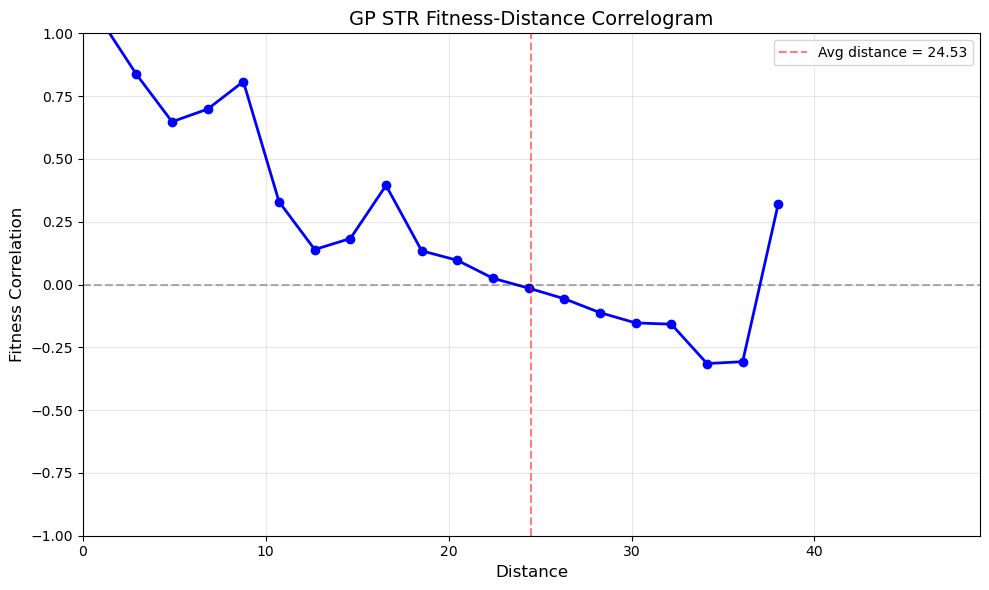


Complete!


In [15]:
rnd.CONFIG(name_type='str', dist_type='coarse')

# Build correlogram
print("\nBuilding correlogram...")
analyzer = correlogram_walks(
    op,
    n_walks=N_WALKS,
    walk_length=WALK_LENGTH,
    n_bins=N_BINS,
    verbose=True
)

x_axis, y_axis = analyzer()

# Display results
results = analyzer.get_results()

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"Solutions sampled: {results['n_solutions']}")
print(f"Pairs analyzed: {results['n_pairs']}")
print(f"Average distance: {results['avg_distance']:.2f}")
print(f"Distance range: [{results['min_distance']:.0f}, {results['max_distance']:.0f}]")
print(f"Fitness: {results['mean_fitness']:.2f} ± {results['std_fitness']:.2f}")
print(f"Filled bins: {len(y_axis)}/{N_BINS}")

if len(y_axis) > 0:
    print(f"\nCorrelation at d=0: {y_axis[0]:.4f}")

    # Interpret landscape
    if y_axis[0] > 0.8:
        print("  → Very smooth landscape at short distances")
    elif y_axis[0] > 0.5:
        print("  → Moderately smooth landscape")
    else:
        print("  → Rugged landscape")

# Plot
print("\nPlotting correlogram...")
analyzer.plot(title=f"GP STR Fitness-Distance Correlogram")

print("\n" + "="*60)
print("Complete!")
print("="*60)


Building correlogram...
Building correlogram with 40 walks of length 15...
Step 1: Generating random walks...
  Completed 10/40 walks...
  Completed 20/40 walks...
  Completed 30/40 walks...
  Completed 40/40 walks...
  Total solutions generated: 640
Step 2: Computing fitness statistics...
  Mean fitness: 25.4422
  Fitness variance: 10.2029
Step 3: Computing pairwise distances...
  Computing 204480 pairwise distances...
  Processed 100/640 solutions...
  Processed 200/640 solutions...
  Processed 300/640 solutions...
  Processed 400/640 solutions...
  Processed 500/640 solutions...
  Processed 600/640 solutions...
Step 4: Distance statistics:
  Average distance: 24.5480
  Max distance: 39.0000
  Min distance: 0.0000
Step 5: Binning distances into 20 bins...
  Non-empty bins: 20/20

Correlogram completed!
Correlation at distance=0: 1.1222
Correlation at avg distance: -0.0165

RESULTS
Solutions sampled: 640
Pairs analyzed: 204480
Average distance: 24.55
Distance range: [0, 39]
Fitness: 

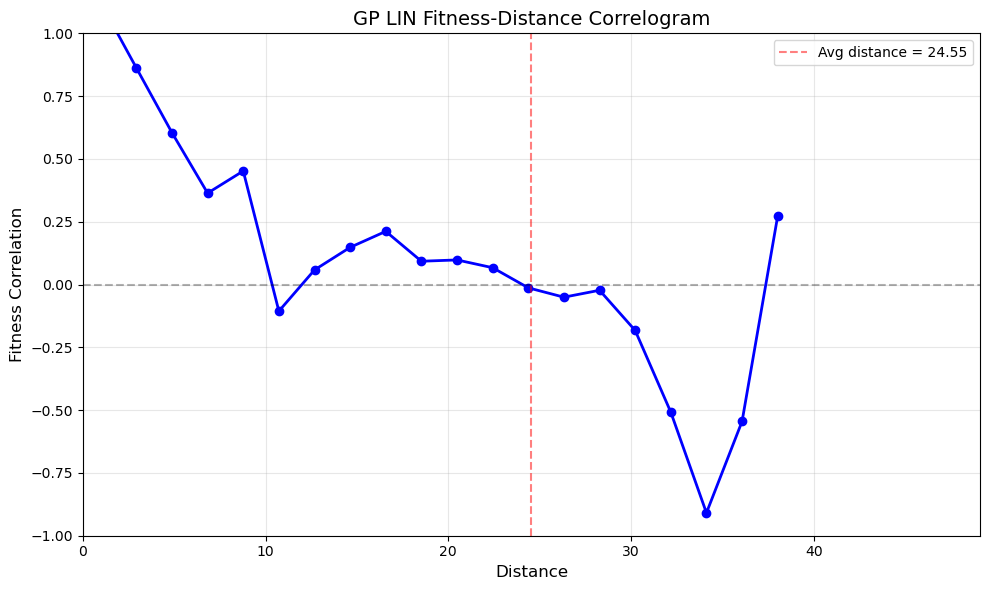


Complete!


In [16]:
rnd.CONFIG(name_type='lin', dist_type='coarse')

# Build correlogram
print("\nBuilding correlogram...")
analyzer = correlogram_walks(
    op,
    n_walks=N_WALKS,
    walk_length=WALK_LENGTH,
    n_bins=N_BINS,
    verbose=True
)

x_axis, y_axis = analyzer()

# Display results
results = analyzer.get_results()

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"Solutions sampled: {results['n_solutions']}")
print(f"Pairs analyzed: {results['n_pairs']}")
print(f"Average distance: {results['avg_distance']:.2f}")
print(f"Distance range: [{results['min_distance']:.0f}, {results['max_distance']:.0f}]")
print(f"Fitness: {results['mean_fitness']:.2f} ± {results['std_fitness']:.2f}")
print(f"Filled bins: {len(y_axis)}/{N_BINS}")

if len(y_axis) > 0:
    print(f"\nCorrelation at d=0: {y_axis[0]:.4f}")

    # Interpret landscape
    if y_axis[0] > 0.8:
        print("  → Very smooth landscape at short distances")
    elif y_axis[0] > 0.5:
        print("  → Moderately smooth landscape")
    else:
        print("  → Rugged landscape")

# Plot
print("\nPlotting correlogram...")
analyzer.plot(title=f"GP LIN Fitness-Distance Correlogram")

print("\n" + "="*60)
print("Complete!")
print("="*60)